In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
 
gpu = tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


In [3]:
import warnings
warnings.filterwarnings("ignore")
SIZE = 299
path_to_train = os.path.abspath("")+'\\train\\'

In [4]:
import re
data = pd.read_csv('full_train_labels.csv')

In [5]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target']):
    labels = re.sub("[^a-zA-Z0-9]",", ",labels)
    labels = labels.replace(' ','')
    labels = labels.replace(',,', ',')
    labels = labels.replace(',', ' ')
    labels = labels.strip()
    labels = labels.split(' ')
    labels = list(map(int, labels))
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':labels})

train_dataset_info = np.array(train_dataset_info)
print(train_dataset_info.shape)
print(train_dataset_info[0]['labels'])

(42611,)
[16, 0]


In [6]:
class data_generator:
   def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []#배치사이즈의 이미지 픽셀값이 담길 리스트
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)#load_image는 클레스의 또다른 메서드, 이미지를 경로에 따라 열고, stack & resize  
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels #배치사이즈로 images를 뱉어내는 제네레이터

   def load_image(path, shape):
           R = np.array(Image.open(path+'_red.png'))#차원 (512, 512)
           Y = np.array(Image.open(path+'_yellow.png'))
           G = np.array(Image.open(path+'_green.png'))
           B = np.array(Image.open(path+'_blue.png'))
           
           image = np.stack((
            R*0, 
            G,
            B*0,
            ), -1)#차원 (512, 512, 3)'''
           image = cv2.resize(image, (shape[0], shape[1]))#사용자 정의에 따라 resize
           return image
      
   def augment(image):#image augumentation
           augment_img = iaa.Sequential([
           iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

           image_aug = augment_img.augment_image(image)
           return image_aug

(512, 512)
(512, 512, 3)


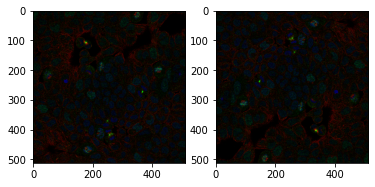

In [7]:
#data generator 메서드 확인하기

path = train_dataset_info[0]['path']
image_red = np.array(Image.open(path+'_red.png'))#흑백으로 되는듯??(=convert('L'))
image_blue = np.array(Image.open(path+'_blue.png'))
image_green = np.array(Image.open(path+'_green.png'))
image = np.stack((image_red, image_green, image_blue), -1)
print(image_red.shape)
print(image.shape)

import matplotlib.pyplot as plt



augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),#90도 만큼 회전
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),#배열을 좌우로 뒤집기, 0.5는 이미지의 50%를 뒤집는다는 뜻
                iaa.Flipud(0.5),#배열을 위아래 방향으로 뒤집기
            ])], random_order=True)


image_aug = augment_img.augment_image(image)


fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(image)
ax2.imshow(image_aug)
plt.show()

In [8]:
# split data into train, valid 인덱스 나누기
from sklearn.model_selection import train_test_split
batch_size = 8
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)
print(train_indexes)
print(train_indexes.shape)

[37757 23753  7379 ...  8942  3585 12367]
(36219,)


In [9]:
# train and valid 제네레이터 형성
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

In [16]:
#모델링

from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, VGG19, InceptionResNetV2
from tensorflow.keras import Model

input_shape = (SIZE, SIZE, 3)
n_classes= 28

def create_model_incresv2():
    base_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)   
    base_model.trainable = False
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model



def create_model_incv3():
    base_model = InceptionV3(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)   
    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

def create_model_resnet50():
    base_model = ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)   
  
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

def create_model_vgg16():
    base_model = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=input_shape)   
   
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)#커널크기 1로 하고, 갯수 32로 한거 신의 한수인듯
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model
    
def create_model_vgg19():
    base_model = VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=input_shape)   
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

In [17]:
model = create_model_incresv2()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
batch_normalization_407 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_407 (Conv2D)          (None, 8, 8, 32)          49184     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098

In [18]:
#callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model_sig_g-only.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [19]:
from tensorflow.keras import backend as K
import tensorflow as tf

def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [20]:
batch_size = 12

In [21]:
from tensorflow.keras.optimizers import Adam
# train all layers
for layer in model.layers:
    layer.trainable = True
    
model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['binary_accuracy', f1])#다중 레이블은 'binary_acccuracy'로 계산

model.fit_generator(  
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=20, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/20
3019/3019 [==============================] - 919s 300ms/step - loss: 0.1689 - binary_accuracy: 0.9432 - f1: 0.1390 - val_loss: 0.1814 - val_binary_accuracy: 0.9367 - val_f1: 0.1873

Epoch 00001: val_loss improved from inf to 0.18138, saving model to best_model_sig_g-only.h5
Epoch 2/20
3019/3019 [==============================] - 996s 330ms/step - loss: 0.1517 - binary_accuracy: 0.9486 - f1: 0.1548 - val_loss: 0.1531 - val_binary_accuracy: 0.9457 - val_f1: 0.2137

Epoch 00002: val_loss improved from 0.18138 to 0.15311, saving model to best_model_sig_g-only.h5
Epoch 3/20
3019/3019 [==============================] - 761s 252ms/step - loss: 0.1487 - binary_accuracy: 0.9491 - f1: 0.1585 - val_loss: 0.1621 - val_binary_accuracy: 0.9439 - val_f1: 0.1940

Epoch 00003: val_loss did not improve from 0.15311
Epoch 4/20
3019/3019 [==============================] - 803s 266ms/step - loss: 0.1427 - binary_accuracy: 0.9506 - f1: 0.1665 - val_loss: 0.1361 - val_binary_accuracy: 0.9524 - val

뒤에는 RGBY 채널